In [31]:
import sys
from pathlib import Path

# Add project root to path
project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))

In [38]:
##Simulate the data
from simulator.simulator_Multi_acoustic_tracking import (
    DynamicsConfig,
    ScenarioConfig,
    simulate_acoustic_dataset  # Changed from simulate_multi_target_tracking
)
import numpy as np
import matplotlib.pyplot as plt


cfg = ScenarioConfig(
    n_targets=4,
    n_steps=40,  
    area_xy=(40.0, 40.0),
    sensor_grid_shape=(5, 5),
    psi=10.0,
    d0=0.1,
    seed=56,
    use_article_init=True,
)
dyn_cfg = DynamicsConfig(dt=1.0)

mat_data = simulate_acoustic_dataset(cfg, dyn_cfg)  

np.savez("../simulator/data/acoustic_sim.npz", **mat_data)  
print("Simulation complete. Data saved as 'acoustic_sim.npz'")

Simulation complete. Data saved as 'acoustic_sim.npz'


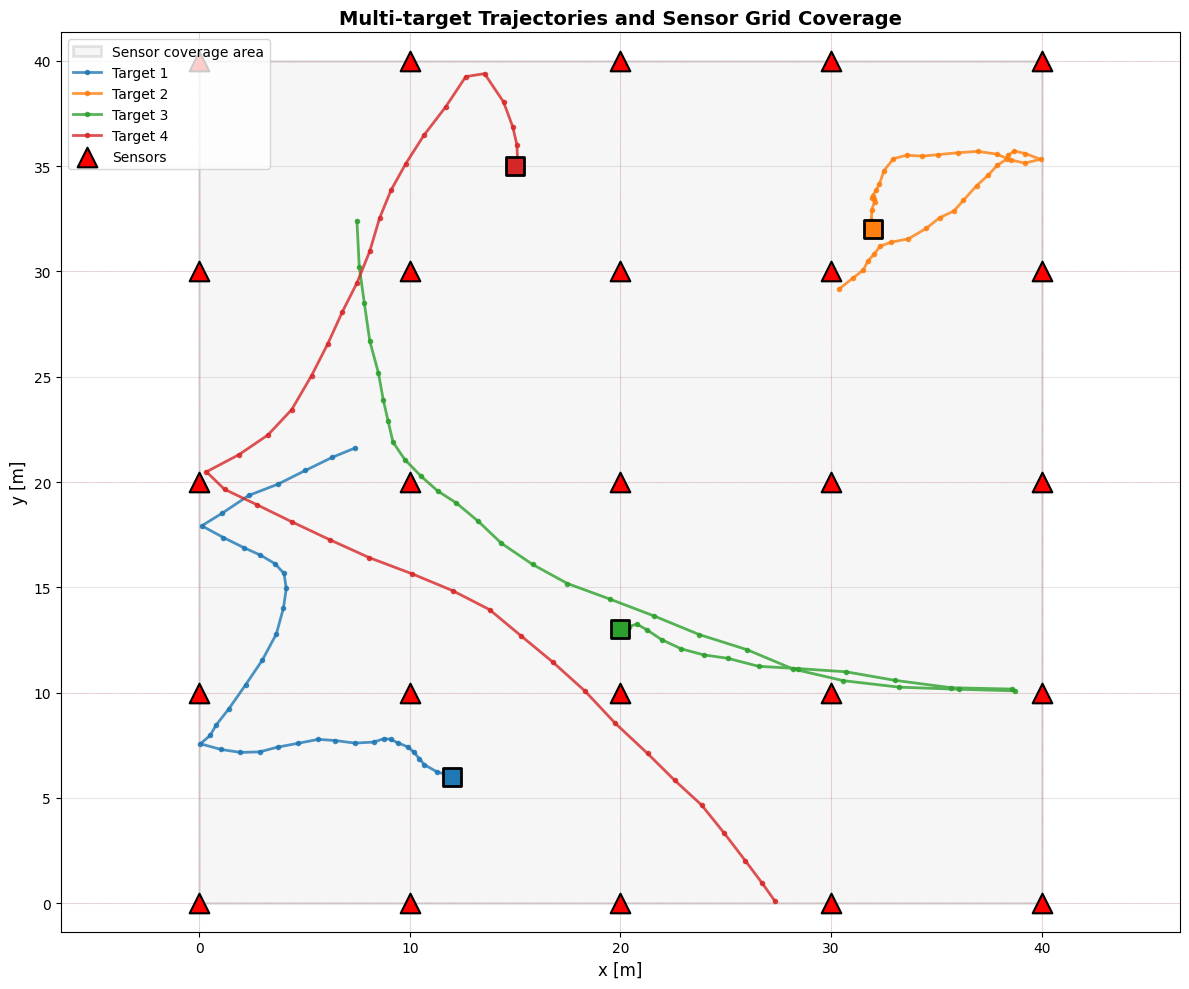

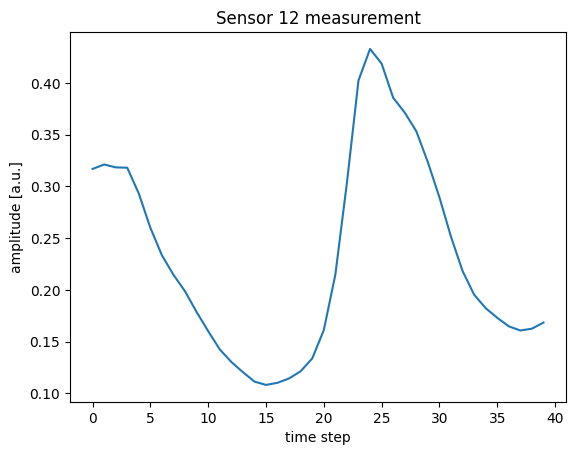

In [39]:
from matplotlib.patches import Rectangle

plt.figure(figsize=(12, 10))

coverage_rect = Rectangle((0, 0), cfg.area_xy[0], cfg.area_xy[1], 
                          linewidth=2, edgecolor='gray', 
                          facecolor='lightgray', alpha=0.2, 
                          label='Sensor coverage area')
plt.gca().add_patch(coverage_rect)

for c in range(cfg.n_targets):
    plt.plot(mat_data["P"][:, c, 0], mat_data["P"][:, c, 1], 
            linewidth=2, marker='o', markersize=3, 
            label=f"Target {c+1}", alpha=0.8)
    plt.scatter(mat_data["P"][0, c, 0], mat_data["P"][0, c, 1], 
               marker='s', s=150, edgecolors='black', linewidths=2, zorder=10)

plt.scatter(mat_data["S"][:, 0], mat_data["S"][:, 1], 
           marker="^", s=200, c='red', edgecolors='black', 
           linewidths=1.5, label="Sensors", zorder=5)

for x_pos in np.unique(mat_data["S"][:, 0]):
    plt.axvline(x=x_pos, color='red', linestyle=':', alpha=0.3, linewidth=0.5)
for y_pos in np.unique(mat_data["S"][:, 1]):
    plt.axhline(y=y_pos, color='red', linestyle=':', alpha=0.3, linewidth=0.5)

plt.xlabel("x [m]", fontsize=12)
plt.ylabel("y [m]", fontsize=12)
plt.title("Multi-target Trajectories and Sensor Grid Coverage", 
         fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

plt.figure()
sensor_idx = (cfg.sensor_grid_shape[0] * cfg.sensor_grid_shape[1]) // 2
plt.plot(mat_data["Z"][:, sensor_idx])
plt.xlabel("time step")
plt.ylabel("amplitude [a.u.]")
plt.title(f"Sensor {sensor_idx} measurement")
plt.show()


In [40]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from models.LEDH_particle_filter import LEDHFlowPF, LEDHConfig, PFState
from models.EDH_particle_filter import EDHFlowPF, EDHConfig
from models.extended_kalman_filter import ExtendedKalmanFilter, EKFState
import time

data = np.load("../simulator/data/acoustic_sim.npz")
X_true = data["X"]
P_true = data["P"]
S = data["S"]
Z = data["Z"]
meta = data["meta"]

T, C, _ = X_true.shape
n_sensors = S.shape[0]
psi, d0 = meta[2], meta[3]
meas_noise_std = 0.1  

print(f"Data loaded: T={T}, C={C}, n_sensors={n_sensors}")
print(f"Psi={psi}, d0={d0}, meas_noise_std={meas_noise_std}")


def compute_omat(X_true_t, X_est_t, p=1):
    """
    Compute OMAT distance between true and estimated positions.
    
    Parameters
    ----------
    X_true_t : np.ndarray
        (C, 2) true positions
    X_est_t : np.ndarray
        (C, 2) estimated positions
    p : float
        Scalar parameter (default p=1)
        
    Returns
    -------
    float
        OMAT distance
    """
    C = X_true_t.shape[0]
    dist_matrix = np.zeros((C, C))
    for i in range(C):
        for j in range(C):
            dist_matrix[i, j] = np.linalg.norm(X_true_t[i] - X_est_t[j])
    
    row_ind, col_ind = linear_sum_assignment(dist_matrix)
    omat = (1.0 / C) * np.sum(dist_matrix[row_ind, col_ind] ** p) ** (1.0 / p)
    return omat

from simulator.simulator_Multi_acoustic_tracking import article_process_noise_cov
Q_filter = article_process_noise_cov()

R = np.eye(n_sensors) * (meas_noise_std ** 2)


def g_filter(x, u=None, v=None):
    """
    CV process model: x_k = F @ x_{k-1} + v
    
    Parameters
    ----------
    x : np.ndarray
        (4,) state [x, y, vx, vy]
    u : np.ndarray, optional
        Control input (unused)
    v : np.ndarray, optional
        (4,) process noise
        
    Returns
    -------
    np.ndarray
        (4,) predicted state
    """
    dt = 1.0
    F = np.array([
        [1.0, 0.0, dt, 0.0],
        [0.0, 1.0, 0.0, dt],
        [0.0, 0.0, 1.0, 0.0],
        [0.0, 0.0, 0.0, 1.0]
    ])
    if v is None:
        v = np.zeros(4)
    return F @ x + v


def h_acoustic(x):
    """
    Acoustic observation model for single target.
    
    Parameters
    ----------
    x : np.ndarray
        (4,) state [x, y, vx, vy]
        
    Returns
    -------
    np.ndarray
        (n_sensors,) measurements
    """
    pos = x[:2]
    z = np.zeros(n_sensors)
    for s in range(n_sensors):
        dist_sq = np.sum((pos - S[s]) ** 2)
        z[s] = psi / (dist_sq + d0)
    return z


def h_multi(X_multi):
    """
    Multi-target observation model.
    
    Parameters
    ----------
    X_multi : np.ndarray
        (C, 4) states for C targets
        
    Returns
    -------
    np.ndarray
        (n_sensors,) sum of contributions from all targets
    """
    z_total = np.zeros(n_sensors)
    for c in range(C):
        z_total += h_acoustic(X_multi[c])
    return z_total


def jac_h_acoustic(x):
    """
    Jacobian of h w.r.t. x for single target.
    
    Parameters
    ----------
    x : np.ndarray
        (4,) state
        
    Returns
    -------
    np.ndarray
        (n_sensors, 4) Jacobian
    """
    pos = x[:2]
    H = np.zeros((n_sensors, 4))
    for s in range(n_sensors):
        diff = pos - S[s]
        dist_sq = np.sum(diff ** 2)
        denom = (dist_sq + d0) ** 2
        H[s, 0] = -2.0 * psi * diff[0] / denom
        H[s, 1] = -2.0 * psi * diff[1] / denom
        H[s, 2] = 0.0
        H[s, 3] = 0.0
    return H


def log_trans_pdf(xk, xkm1):
    """
    Log transition PDF: log p(x_k | x_{k-1})
    
    Parameters
    ----------
    xk : np.ndarray
        Current state
    xkm1 : np.ndarray
        Previous state
        
    Returns
    -------
    float
        Log probability
    """
    dt = 1.0
    F = np.array([
        [1.0, 0.0, dt, 0.0],
        [0.0, 1.0, 0.0, dt],
        [0.0, 0.0, 1.0, 0.0],
        [0.0, 0.0, 0.0, 1.0]
    ])
    diff = xk - F @ xkm1
    log_det = np.log(np.linalg.det(2 * np.pi * Q_filter))
    return -0.5 * (diff.T @ np.linalg.solve(Q_filter, diff) + log_det)


def log_like_pdf_single(z, x):
    """
    Log likelihood PDF for single target: log p(z | x)
    
    Parameters
    ----------
    z : np.ndarray
        Measurement
    x : np.ndarray
        State
        
    Returns
    -------
    float
        Log likelihood
    """
    h_x = h_acoustic(x)
    diff = z - h_x
    log_det = np.log(np.linalg.det(2 * np.pi * R))
    return -0.5 * (diff.T @ np.linalg.solve(R, diff) + log_det)


def jac_g(x, u):
    """
    Jacobian of g w.r.t. x
    
    Parameters
    ----------
    x : np.ndarray
        State
    u : np.ndarray
        Control input
        
    Returns
    -------
    np.ndarray
        (4, 4) Jacobian matrix
    """
    dt = 1.0
    return np.array([
        [1.0, 0.0, dt, 0.0],
        [0.0, 1.0, 0.0, dt],
        [0.0, 0.0, 1.0, 0.0],
        [0.0, 0.0, 0.0, 1.0]
    ])


print("Model functions defined")
print("Model functions defined")


Data loaded: T=40, C=4, n_sensors=25
Psi=10.0, d0=0.1, meas_noise_std=0.1
Model functions defined
Model functions defined


In [41]:
# Helper classes and functions for particle flow filters

# EKF Tracker wrapper (needed for both EDH and LEDH)
class EKFTracker:
    """
    Wrapper for ExtendedKalmanFilter to match GaussianTracker protocol.
    
    This class wraps an EKF to provide a consistent interface for use
    with particle flow filters (EDH and LEDH).
    
    Attributes
    ----------
    ekf : ExtendedKalmanFilter
        The underlying extended Kalman filter.
    state : EKFState
        Current state estimate.
    past_mean : np.ndarray
        State mean from the previous time step.
    """
    
    def __init__(self, ekf, initial_state):
        """
        Initialize the EKF tracker.
        
        Parameters
        ----------
        ekf : ExtendedKalmanFilter
            The EKF instance to wrap.
        initial_state : EKFState
            Initial state estimate.
        """
        self.ekf = ekf
        self.state = initial_state
        self.past_mean = initial_state.mean.copy()
        
    def predict(self):
        """
        Perform prediction step.
        
        Returns
        -------
        tuple[np.ndarray, np.ndarray]
            Predicted mean and covariance.
        """
        self.past_mean = self.state.mean.copy()
        self.state = self.ekf.predict(self.state, u=None)
        return self.state.mean, self.state.cov
    
    def update(self, z_k):
        """
        Perform measurement update step.
        
        Parameters
        ----------
        z_k : np.ndarray
            Measurement vector.
            
        Returns
        -------
        tuple[np.ndarray, np.ndarray]
            Updated mean and covariance.
        """
        self.state = self.ekf.update(self.state, z_k)
        return self.state.mean, self.state.cov
    
    def get_past_mean(self):
        """
        Get the state mean from the previous time step.
        
        Returns
        -------
        np.ndarray
            Previous state mean.
        """
        return self.past_mean


def initialize_target_states(rng, area_bounds=(40.0, 40.0)):
    """
    Initialize state estimates for all targets.
    
    Samples initial means from Gaussian distributions centered at true
    initial states. Rejects samples outside the tracking area.
    
    Parameters
    ----------
    rng : np.random.Generator
        Random number generator.
    area_bounds : tuple[float, float], optional
        Tracking area bounds (width, height), by default (40.0, 40.0).
        
    Returns
    -------
    np.ndarray
        Initial state means of shape (C, 4).
    """
    X_init_mean = np.zeros((C, 4))
    for c in range(C):
        # Sample and reject if outside area
        while True:
            pos_noise = rng.normal(0, 10.0, size=2)
            vel_noise = rng.normal(0, 1.0, size=2)
            X_init_mean[c, :2] = X_true[0, c, :2] + pos_noise
            X_init_mean[c, 2:] = X_true[0, c, 2:] + vel_noise
            
            # Check if inside area
            if 0 <= X_init_mean[c, 0] <= area_bounds[0] and \
               0 <= X_init_mean[c, 1] <= area_bounds[1]:
                break
    return X_init_mean

print("Helper classes and functions defined")

Helper classes and functions defined


In [42]:
# Joint Multi-Target Particle Filter Implementation
# measurements are the sum of all target contributions,
# so we need to track all targets jointly in a single particle filter.

def run_joint_multi_target_filter(filter_type="LEDH", n_particles=500, seed=42, 
                                  track_trajectory=False, n_lambda_steps=64):
    """
    Run JOINT multi-target tracking with particle flow filters.
    
    This implementation handles the fact that measurements are
    the sum of contributions from all targets by tracking all targets
    jointly in a single particle filter.
    
    Parameters
    ----------
    filter_type : str, optional
        Type of particle filter: "LEDH" or "EDH", by default "LEDH".
    n_particles : int, optional
        Number of particles, by default 500.
    seed : int, optional
        Random seed for reproducibility, by default 42.
    track_trajectory : bool, optional
        If True, store full trajectory estimates, by default False.
    n_lambda_steps : int, optional
        Number of lambda steps for particle flow, by default 64.
    Returns
    -------
    dict
        Dictionary containing:
        - omat_history : np.ndarray, OMAT distances over time
        - ess_history : np.ndarray, ESS values over time
        - exec_time : float, execution time in seconds
        - final_estimates : np.ndarray, final state estimates
        - avg_omat : float, average OMAT distance
        - avg_ess : float, average ESS
        - n_particles : int, number of particles used
        - trajectory : np.ndarray (optional), full trajectory if tracked
    """
    rng = np.random.default_rng(seed)
    
    # Initialize state estimates
    X_init_mean = initialize_target_states(rng)
    
    # Joint state: stack all targets [target1_state, target2_state, ...]
    # Each target has 4D state [x, y, vx, vy], so joint state is 16D for 4 targets
    joint_mean = X_init_mean.flatten()  # (16,) for 4 targets
    joint_dim = C * 4  # 16
    
    # Initial covariance (block diagonal - targets are initially independent)
    P_single = np.diag([10.0**2, 10.0**2, 1.0**2, 1.0**2])
    P_init_joint = np.zeros((joint_dim, joint_dim))
    for c in range(C):
        P_init_joint[c*4:(c+1)*4, c*4:(c+1)*4] = P_single
    
    # Joint process noise covariance (block diagonal)
    Q_joint = np.zeros((joint_dim, joint_dim))
    for c in range(C):
        Q_joint[c*4:(c+1)*4, c*4:(c+1)*4] = Q_filter
    
    # Joint process model
    def g_joint(x_joint, u=None, v=None):
        """Process all targets independently."""
        if v is None:
            v = np.zeros(joint_dim)
        x_next = np.zeros(joint_dim)
        for c in range(C):
            x_c = x_joint[c*4:(c+1)*4]
            v_c = v[c*4:(c+1)*4]
            x_next[c*4:(c+1)*4] = g_filter(x_c, u, v_c)
        return x_next
    
    # Joint observation model
    def h_joint(x_joint):
        """Sum contributions from all targets."""
        z = np.zeros(n_sensors)
        for c in range(C):
            x_c = x_joint[c*4:(c+1)*4]
            z += h_acoustic(x_c)
        return z
    
    # Joint Jacobian
    def jac_h_joint(x_joint):
        """Jacobian of joint observation model."""
        H = np.zeros((n_sensors, joint_dim))
        for c in range(C):
            x_c = x_joint[c*4:(c+1)*4]
            H[:, c*4:(c+1)*4] = jac_h_acoustic(x_c)
        return H
    
    # Joint log transition PDF
    def log_trans_pdf_joint(xk, xkm1):
        """Log p(x_k | x_{k-1}) for joint state."""
        diff = xk - g_joint(xkm1)
        log_det = np.log(np.linalg.det(2 * np.pi * Q_joint))
        return -0.5 * (diff.T @ np.linalg.solve(Q_joint, diff) + log_det)
    
    # Joint log likelihood PDF
    def log_like_pdf_joint(z, x):
        """Log p(z | x) for joint state."""
        h_x = h_joint(x)
        diff = z - h_x
        log_det = np.log(np.linalg.det(2 * np.pi * R))
        return -0.5 * (diff.T @ np.linalg.solve(R, diff) + log_det)
    
    # Joint Jacobian for process model
    def jac_g_joint(x, u):
        """Jacobian of joint process model (block diagonal)."""
        dt = 1.0
        F_single = np.array([
            [1.0, 0.0, dt, 0.0],
            [0.0, 1.0, 0.0, dt],
            [0.0, 0.0, 1.0, 0.0],
            [0.0, 0.0, 0.0, 1.0]
        ])
        F_joint = np.zeros((joint_dim, joint_dim))
        for c in range(C):
            F_joint[c*4:(c+1)*4, c*4:(c+1)*4] = F_single
        return F_joint
    
    # Create EKF tracker for joint state
    ekf = ExtendedKalmanFilter(
        g=g_joint, h=h_joint, 
        jac_g=jac_g_joint, jac_h=jac_h_joint,
        Q=Q_joint, R=R
    )
    ekf_state = EKFState(mean=joint_mean, cov=P_init_joint.copy(), t=0)
    tracker = EKFTracker(ekf, ekf_state)
    
    # Create particle filter
    if filter_type == "LEDH":
        cfg = LEDHConfig(
            n_particles=n_particles,
            n_lambda_steps=n_lambda_steps,
            resample_ess_ratio=0.5,
            rng=np.random.default_rng(seed)
        )
        pf = LEDHFlowPF(
            tracker=tracker,
            g=g_joint,
            h=h_joint,
            jacobian_h=jac_h_joint,
            log_trans_pdf=log_trans_pdf_joint,
            log_like_pdf=log_like_pdf_joint,
            R=R,
            config=cfg
        )
    else:  # EDH
        cfg = EDHConfig(
            n_particles=n_particles,
            n_lambda_steps=n_lambda_steps,
            resample_ess_ratio=0.5,
            flow_integrator="rk4",
            rng=np.random.default_rng(seed)
        )
        pf = EDHFlowPF(
            tracker=tracker,
            g=g_joint,
            h=h_joint,
            jacobian_h=jac_h_joint,
            log_trans_pdf=log_trans_pdf_joint,
            log_like_pdf=log_like_pdf_joint,
            R=R,
            config=cfg
        )
    
    # Initialize particles
    state = pf.init_from_gaussian(joint_mean, P_init_joint)
    
    # Run filtering
    omat_history = []
    ess_history = []
    trajectory = np.zeros((T, C, 2)) if track_trajectory else None
    if track_trajectory:
        trajectory[0] = X_init_mean[:, :2]
    
    start_time = time.time()
    
    for t in range(1, T):
        z_t = Z[t]
        
        # Process noise sampler for joint state
        def process_noise_sampler(N, nx):
            return rng.multivariate_normal(np.zeros(nx), Q_joint, size=N)
        
        # Perform filter step
        state = pf.step(state, z_t, u_km1=None, 
                      process_noise_sampler=process_noise_sampler)
        
        # Extract position estimates for all targets
        X_est_t = np.zeros((C, 2))
        for c in range(C):
            X_est_t[c] = state.mean[c*4:c*4+2]  # Extract [x, y] for target c
        
        # Store trajectory if tracking
        if track_trajectory:
            trajectory[t] = X_est_t
        
        # Compute OMAT for this timestep
        omat = compute_omat(P_true[t], X_est_t, p=1)
        omat_history.append(omat)
        
        # Compute ESS
        ess = 1.0 / np.sum(state.weights ** 2)
        ess_history.append(ess)
        
        if (t % 20 == 0):
            print(f"  Step {t}/{T-1}: OMAT={omat:.4f}, ESS={ess:.1f}")
    
    exec_time = time.time() - start_time
    
    # Extract final estimates
    final_estimates = np.zeros((C, 4))
    for c in range(C):
        final_estimates[c] = state.mean[c*4:(c+1)*4]
    
    results = {
        'omat_history': np.array(omat_history),
        'ess_history': np.array(ess_history),
        'exec_time': exec_time,
        'final_estimates': final_estimates,
        'avg_omat': np.mean(omat_history),
        'avg_ess': np.mean(ess_history),
        'n_particles': n_particles
    }
    
    if track_trajectory:
        results['trajectory'] = trajectory
    
    return results

print("Joint multi-target filter functions defined!")

Joint multi-target filter functions defined!


In [43]:
# Run filters 
print("\n" + "="*60)
print("Running Joint Multi-Target Tracking Filters")
print("="*60)
print(f"Q[0,0] = {Q_filter[0,0]:.6f}, R[0,0] = {R[0,0]:.6f}")
print(f"T = {T} time steps")
print("="*60)

# Run LEDH filter (with trajectory for later plotting)
print("\nRunning JOINT LEDH Particle Filter...")
ledh_joint_results = run_joint_multi_target_filter(
    filter_type="LEDH", n_particles=500, seed=42, track_trajectory=True, n_lambda_steps=64
)
print(f"  Average OMAT: {ledh_joint_results['avg_omat']:.4f}")
print(f"  Average ESS: {ledh_joint_results['avg_ess']:.2f}")
print(f"  Execution time: {ledh_joint_results['exec_time']:.2f} seconds")

# Run EDH filter
print("\nRunning JOINT EDH Particle Filter...")
edh_joint_results = run_joint_multi_target_filter(
    filter_type="EDH", n_particles=500, seed=42, n_lambda_steps=8
)
print(f"  Average OMAT: {edh_joint_results['avg_omat']:.4f}")
print(f"  Average ESS: {edh_joint_results['avg_ess']:.2f}")
print(f"  Execution time: {edh_joint_results['exec_time']:.2f} seconds")

print("\n" + "="*60)
print("Joint filters completed successfully!")
print("="*60)


Running Joint Multi-Target Tracking Filters
Q[0,0] = 0.016667, R[0,0] = 0.010000
T = 40 time steps

Running JOINT LEDH Particle Filter...
  Step 20/39: OMAT=11.0733, ESS=500.0
  Step 20/39: OMAT=11.0733, ESS=500.0
  Average OMAT: 10.6974
  Average ESS: 500.00
  Execution time: 2095.74 seconds

Running JOINT EDH Particle Filter...
  Average OMAT: 10.6974
  Average ESS: 500.00
  Execution time: 2095.74 seconds

Running JOINT EDH Particle Filter...
  Step 20/39: OMAT=13.7662, ESS=500.0
  Step 20/39: OMAT=13.7662, ESS=500.0
  Average OMAT: 10.0492
  Average ESS: 500.00
  Execution time: 6.39 seconds

Joint filters completed successfully!
  Average OMAT: 10.0492
  Average ESS: 500.00
  Execution time: 6.39 seconds

Joint filters completed successfully!


In [44]:
# EKF and UKF Multi-Target Tracking
from models.unscented_kalman_filter import UnscentedKalmanFilter, UKFState

def run_multi_target_ekf(seed=42, track_trajectory=False):
    """
    Run multi-target tracking with Extended Kalman Filter.
    
    Parameters
    ----------
    seed : int, optional
        Random seed for reproducibility, by default 42.
    track_trajectory : bool, optional
        If True, store full trajectory estimates, by default False.
    
    Returns
    -------
    dict
        Dictionary containing:
        - omat_history : np.ndarray, OMAT distances over time
        - exec_time : float, execution time in seconds
        - final_estimates : np.ndarray, final state estimates
        - avg_omat : float, average OMAT distance
        - trajectory : np.ndarray (optional), full trajectory if tracked
    """
    rng = np.random.default_rng(seed)
    
    # Initialize state estimates
    X_init_mean = initialize_target_states(rng)
    
    # Initial covariance (same for all targets)
    P_init = np.diag([10.0**2, 10.0**2, 1.0**2, 1.0**2])
    
    # Create separate EKF for each target
    filters = []
    for c in range(C):
        ekf = ExtendedKalmanFilter(
            g=g_filter, h=h_acoustic, 
            jac_g=jac_g, jac_h=jac_h_acoustic,
            Q=Q_filter, R=R
        )
        ekf_state = EKFState(mean=X_init_mean[c], cov=P_init.copy(), t=0)
        filters.append((ekf, ekf_state))
    
    # Run filtering
    omat_history = []
    trajectory = np.zeros((T, C, 2)) if track_trajectory else None
    if track_trajectory:
        trajectory[0] = X_init_mean[:, :2]
    
    start_time = time.time()
    
    for t in range(1, T):
        z_t = Z[t]
        X_est_t = np.zeros((C, 2))
        
        for c in range(C):
            ekf, state = filters[c]
            state = ekf.predict(state, u=None)
            state = ekf.update(state, z_t)
            filters[c] = (ekf, state)
            X_est_t[c] = state.mean[:2]
        
        if track_trajectory:
            trajectory[t] = X_est_t
        
        omat = compute_omat(P_true[t], X_est_t, p=1)
        omat_history.append(omat)
        
        if (t % 20 == 0):
            print(f"  Step {t}/{T-1}: OMAT={omat:.4f}")
    
    exec_time = time.time() - start_time
    final_estimates = np.array([state.mean for _, state in filters])
    
    results = {
        'omat_history': np.array(omat_history),
        'exec_time': exec_time,
        'final_estimates': final_estimates,
        'avg_omat': np.mean(omat_history)
    }
    
    if track_trajectory:
        results['trajectory'] = trajectory
    
    return results


def run_multi_target_ukf(seed=42, track_trajectory=False, track_covariance=False):
    """
    Run multi-target tracking with Unscented Kalman Filter.
    
    Parameters
    ----------
    seed : int, optional
        Random seed for reproducibility, by default 42.
    track_trajectory : bool, optional
        If True, store full trajectory estimates, by default False.
    track_covariance : bool, optional
        If True, compute covariance-based uncertainty measure, by default False.
    
    Returns
    -------
    dict
        Dictionary containing:
        - omat_history : np.ndarray, OMAT distances over time
        - exec_time : float, execution time in seconds
        - final_estimates : np.ndarray, final state estimates
        - avg_omat : float, average OMAT distance
        - trajectory : np.ndarray (optional), full trajectory if tracked
        - cov_trace : np.ndarray (optional), covariance trace if tracked
    """
    rng = np.random.default_rng(seed)
    
    # Initialize state estimates
    X_init_mean = initialize_target_states(rng)
    
    # Initial covariance (same for all targets)
    P_init = np.diag([10.0**2, 10.0**2, 1.0**2, 1.0**2])
    
    # Create separate UKF for each target
    filters = []
    for c in range(C):
        ukf = UnscentedKalmanFilter(
            g=g_filter, h=h_acoustic,
            Q=Q_filter, R=R,
            alpha=1e-3, beta=2.0, kappa=0.0
        )
        ukf_state = UKFState(mean=X_init_mean[c], cov=P_init.copy(), t=0)
        filters.append((ukf, ukf_state))
    
    # Run filtering
    omat_history = []
    trajectory = np.zeros((T, C, 2)) if track_trajectory else None
    cov_trace = [] if track_covariance else None
    
    if track_trajectory:
        trajectory[0] = X_init_mean[:, :2]
    
    start_time = time.time()
    
    for t in range(1, T):
        z_t = Z[t]
        X_est_t = np.zeros((C, 2))
        cov_traces_t = [] if track_covariance else None
        
        for c in range(C):
            ukf, state = filters[c]
            state = ukf.predict(state, u=None)
            state = ukf.update(state, z_t)
            filters[c] = (ukf, state)
            X_est_t[c] = state.mean[:2]
            
            # Track covariance-based uncertainty if requested
            if track_covariance:
                cov_det = np.linalg.det(state.cov)
                eff_dof = 1.0 / (1.0 + cov_det ** (1.0 / 4))
                cov_traces_t.append(eff_dof)
        
        if track_trajectory:
            trajectory[t] = X_est_t
        if track_covariance:
            cov_trace.append(np.mean(cov_traces_t))
        
        omat = compute_omat(P_true[t], X_est_t, p=1)
        omat_history.append(omat)
        
        if (t % 20 == 0):
            print(f"  Step {t}/{T-1}: OMAT={omat:.4f}")
    
    exec_time = time.time() - start_time
    final_estimates = np.array([state.mean for _, state in filters])
    
    results = {
        'omat_history': np.array(omat_history),
        'exec_time': exec_time,
        'final_estimates': final_estimates,
        'avg_omat': np.mean(omat_history)
    }
    
    if track_trajectory:
        results['trajectory'] = trajectory
    if track_covariance:
        results['cov_trace'] = np.array(cov_trace)
    
    return results

# Run EKF filter
print("\nRunning EKF...")
ekf_results = run_multi_target_ekf(seed=42)
print(f"  Average OMAT: {ekf_results['avg_omat']:.4f}")
print(f"  Execution time: {ekf_results['exec_time']:.2f} seconds")

# Run UKF filter (with covariance tracking for ESS plot)
print("\nRunning UKF...")
ukf_results = run_multi_target_ukf(seed=42, track_covariance=True)
print(f"  Average OMAT: {ukf_results['avg_omat']:.4f}")
print(f"  Execution time: {ukf_results['exec_time']:.2f} seconds")

print("\n" + "="*60)
print("All filters completed successfully!")
print("="*60)


Running EKF...
  Step 20/39: OMAT=13.1979
  Average OMAT: 24.7888
  Execution time: 0.03 seconds

Running UKF...
  Step 20/39: OMAT=14.4348
  Average OMAT: 29.4654
  Execution time: 0.10 seconds

All filters completed successfully!



COMPARISON TABLE
      Filter Particles  Avg OMAT Avg ESS  Exec Time (s)
         EKF         - 24.788846       -       0.028480
         UKF         - 29.465447       -       0.095867
 EDH (Joint)       500 10.049208   500.0       6.394524
LEDH (Joint)       500 10.697416   500.0    2095.736958


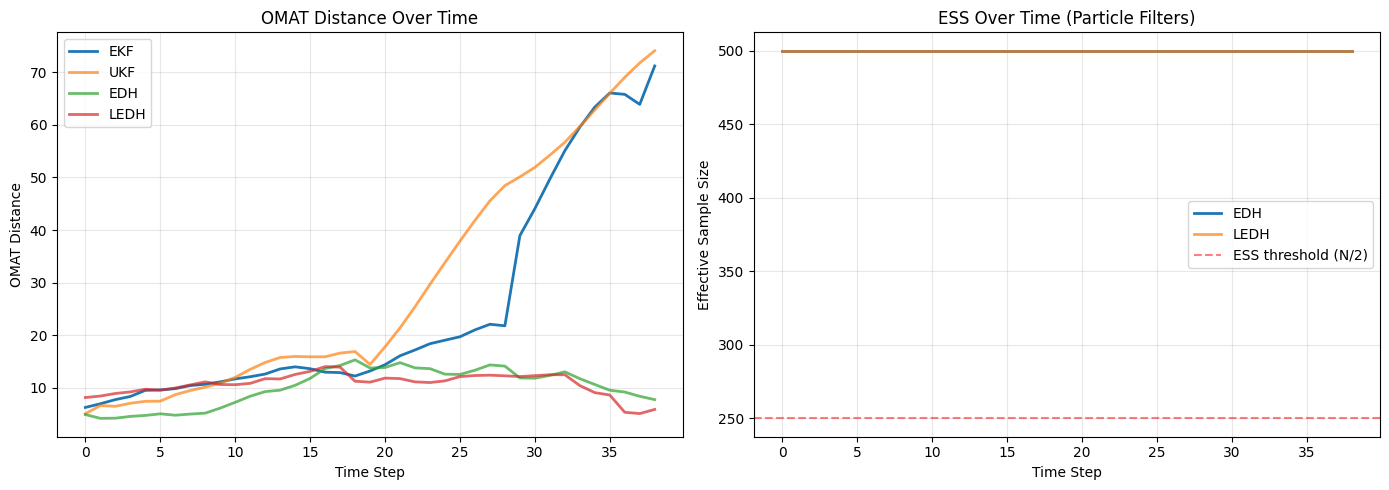


Basic comparison complete!


In [45]:
# Visualization and comparison
import matplotlib.pyplot as plt
# Create comparison table
import pandas as pd

comparison_df = pd.DataFrame({
    'Filter': ['EKF', 'UKF', 'EDH (Joint)', 'LEDH (Joint)'],
    'Particles': ['-', '-', edh_joint_results['n_particles'], ledh_joint_results['n_particles']],
    'Avg OMAT': [ekf_results['avg_omat'], ukf_results['avg_omat'], 
                 edh_joint_results['avg_omat'], ledh_joint_results['avg_omat']],
    'Avg ESS': ['-', '-', edh_joint_results['avg_ess'], ledh_joint_results['avg_ess']],
    'Exec Time (s)': [ekf_results['exec_time'], ukf_results['exec_time'],
                      edh_joint_results['exec_time'], ledh_joint_results['exec_time']]
})

print("\n" + "="*60)
print("COMPARISON TABLE")
print("="*60)
print(comparison_df.to_string(index=False))

# Plot OMAT over time
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(ekf_results['omat_history'], label='EKF', linewidth=2)
plt.plot(ukf_results['omat_history'], label='UKF', linewidth=2, alpha=0.7)
plt.plot(edh_joint_results['omat_history'], label='EDH', linewidth=2, alpha=0.7)
plt.plot(ledh_joint_results['omat_history'], label='LEDH', linewidth=2, alpha=0.7)
plt.xlabel('Time Step')
plt.ylabel('OMAT Distance')
plt.title('OMAT Distance Over Time')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot ESS over time (only for particle filters)
plt.subplot(1, 2, 2)
plt.plot(edh_joint_results['ess_history'], label='EDH', linewidth=2)
plt.plot(ledh_joint_results['ess_history'], label='LEDH', linewidth=2, alpha=0.7)
plt.axhline(y=250, color='r', linestyle='--', label='ESS threshold (N/2)', alpha=0.5)
plt.xlabel('Time Step')
plt.ylabel('Effective Sample Size')
plt.title('ESS Over Time (Particle Filters)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nBasic comparison complete!")

/var/folders/gc/3td1f1k11tl25pfz2pz1jvjh0000gp/T/ipykernel_85113/3175760096.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(omat_data, labels=filter_labels, patch_artist=True,


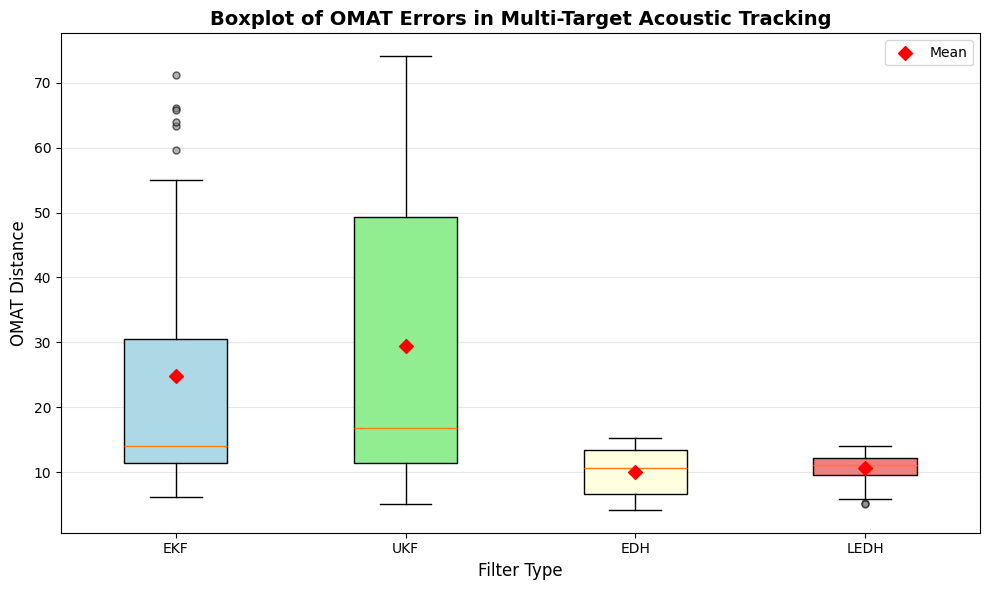


OMAT Statistics
EKF:
  Mean: 24.7888
  Median: 13.9889
  Std: 20.3588
  Min: 6.2682
  Max: 71.1947

UKF:
  Mean: 29.4654
  Median: 16.9001
  Std: 21.9556
  Min: 5.0592
  Max: 74.0915

EDH:
  Mean: 10.0492
  Median: 10.6294
  Std: 3.6234
  Min: 4.1953
  Max: 15.3132

LEDH:
  Mean: 10.6974
  Median: 11.1303
  Std: 2.0739
  Min: 5.1009
  Max: 14.0298



In [46]:
# Boxplot of average OMAT errors in multi-target acoustic tracking
plt.figure(figsize=(10, 6))

# Prepare data for boxplot
omat_data = [
    ekf_results['omat_history'],
    ukf_results['omat_history'],
    edh_joint_results['omat_history'],
    ledh_joint_results['omat_history']
]
filter_labels = ['EKF', 'UKF', 'EDH', 'LEDH']

bp = plt.boxplot(omat_data, labels=filter_labels, patch_artist=True,
                 showfliers=True,  # Show outliers
                 flierprops=dict(marker='o', markerfacecolor='gray', markersize=5, 
                                linestyle='none', markeredgecolor='black', alpha=0.6))

# Customize colors
colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightcoral']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

plt.ylabel('OMAT Distance', fontsize=12)
plt.xlabel('Filter Type', fontsize=12)
plt.title('Boxplot of OMAT Errors in Multi-Target Acoustic Tracking', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# Add mean markers
means = [np.mean(data) for data in omat_data]
plt.scatter(range(1, len(means)+1), means, color='red', marker='D', s=50, zorder=3, label='Mean')
plt.legend()

plt.tight_layout()
plt.show()

# Print statistics
print("\n" + "="*60)
print("OMAT Statistics")
print("="*60)
for label, data in zip(filter_labels, omat_data):
    print(f"{label}:")
    print(f"  Mean: {np.mean(data):.4f}")
    print(f"  Median: {np.median(data):.4f}")
    print(f"  Std: {np.std(data):.4f}")
    print(f"  Min: {np.min(data):.4f}")
    print(f"  Max: {np.max(data):.4f}")
    print()

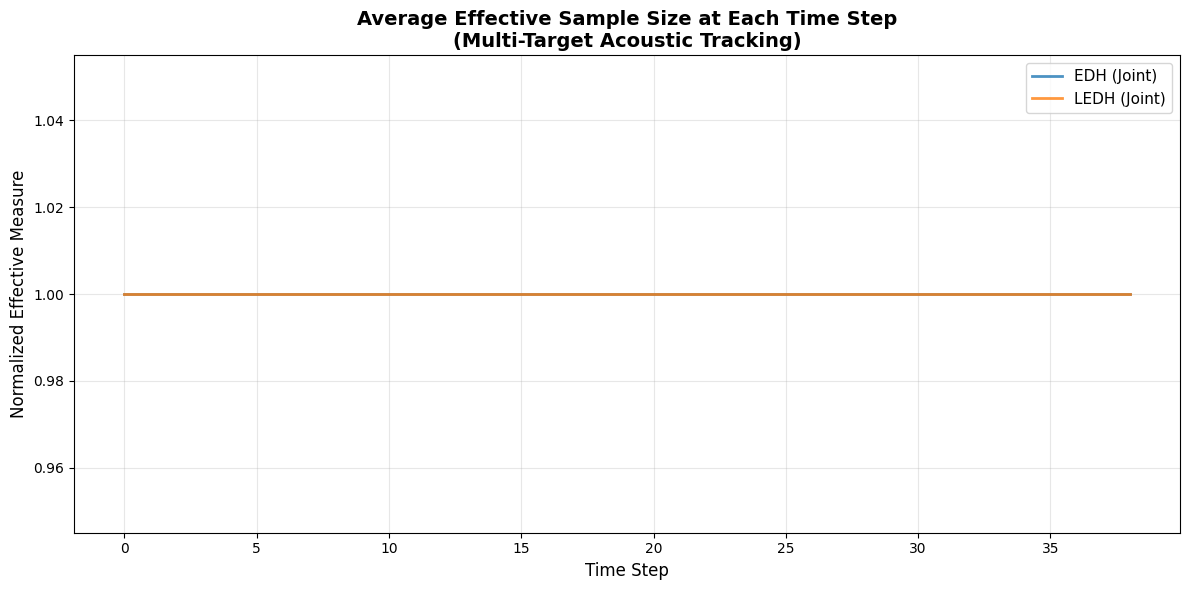

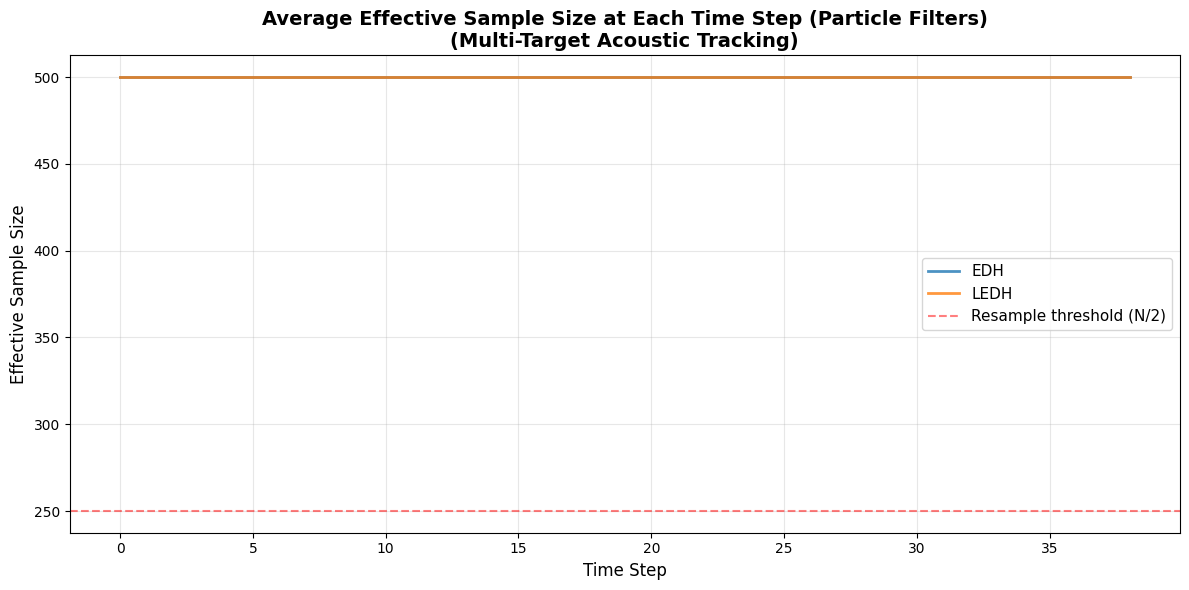


ESS Statistics (Particle Filters)
EDH:
  Mean ESS: 500.00
  Min ESS: 500.00
  Max ESS: 500.00

LEDH:
  Mean ESS: 500.00
  Min ESS: 500.00
  Max ESS: 500.00

All visualizations complete!


In [47]:
# Average effective sample size at each time step for UKF, EDH and LEDH

# Extract UKF covariance trace (already computed during filter run)
ukf_cov_trace = ukf_results['cov_trace']

# Plot Average Effective Sample Size
plt.figure(figsize=(12, 6))

# Normalize all metrics to [0, 1] for comparison
# For particle filters, ESS is in range [0, n_particles]
edh_ess_normalized = edh_joint_results['ess_history'] / edh_joint_results['n_particles']
ledh_ess_normalized = ledh_joint_results['ess_history'] / ledh_joint_results['n_particles']
# UKF metric is already in [0, 1] range

plt.plot(edh_ess_normalized, label='EDH (Joint)', linewidth=2, alpha=0.8)
plt.plot(ledh_ess_normalized, label='LEDH (Joint)', linewidth=2, alpha=0.8)

plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Normalized Effective Measure', fontsize=12)
plt.title('Average Effective Sample Size at Each Time Step\n(Multi-Target Acoustic Tracking)', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Also plot the raw ESS values for particle filters
plt.figure(figsize=(12, 6))

plt.plot(edh_joint_results['ess_history'], label='EDH', linewidth=2, alpha=0.8)
plt.plot(ledh_joint_results['ess_history'], label='LEDH', linewidth=2, alpha=0.8)
plt.axhline(y=250, color='r', linestyle='--', label='Resample threshold (N/2)', alpha=0.5)

plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Effective Sample Size', fontsize=12)
plt.title('Average Effective Sample Size at Each Time Step (Particle Filters)\n(Multi-Target Acoustic Tracking)', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("ESS Statistics (Particle Filters)")
print("="*60)
print(f"EDH:")
print(f"  Mean ESS: {np.mean(edh_joint_results['ess_history']):.2f}")
print(f"  Min ESS: {np.min(edh_joint_results['ess_history']):.2f}")
print(f"  Max ESS: {np.max(edh_joint_results['ess_history']):.2f}")
print(f"\nLEDH:")
print(f"  Mean ESS: {np.mean(ledh_joint_results['ess_history']):.2f}")
print(f"  Min ESS: {np.min(ledh_joint_results['ess_history']):.2f}")
print(f"  Max ESS: {np.max(ledh_joint_results['ess_history']):.2f}")

print("\nAll visualizations complete!")

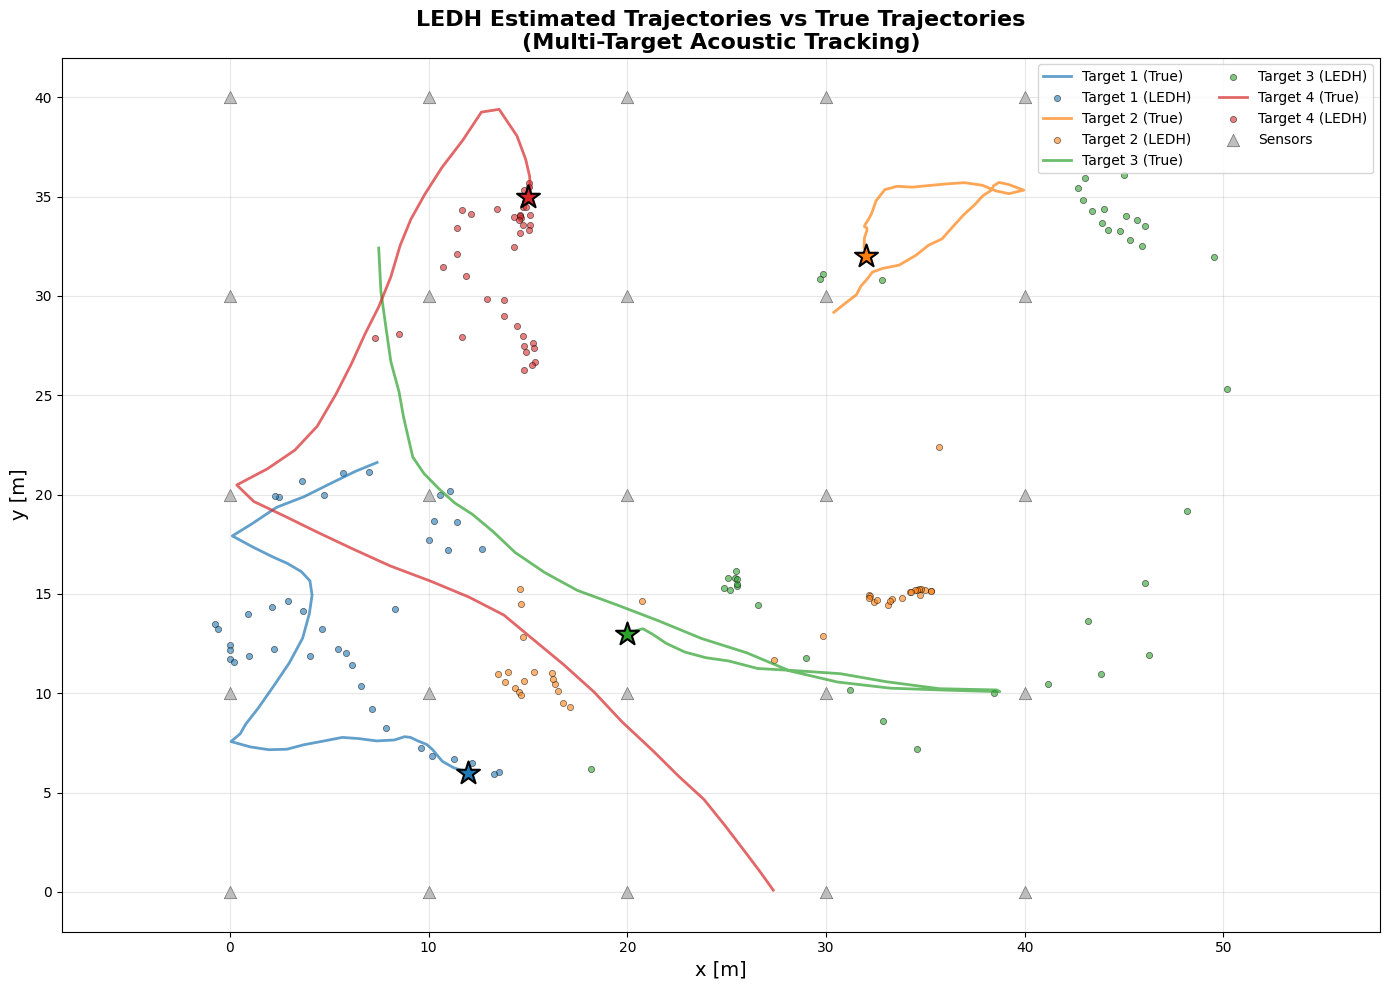

Trajectory plot complete!


In [48]:
# Plot LEDH estimated trajectories vs true trajectories
# Extract trajectory from LEDH joint results (already computed with trajectory tracking)
ledh_trajectory = ledh_joint_results['trajectory']

# Plot trajectories
plt.figure(figsize=(14, 10))

# Define colors for each target
target_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for c in range(C):
    # Plot true trajectory as solid line
    plt.plot(P_true[:, c, 0], P_true[:, c, 1], 
             color=target_colors[c], linestyle='-', linewidth=2, 
             label=f'Target {c+1} (True)', alpha=0.7)
    
    # Plot LEDH estimated trajectory as dots
    plt.scatter(ledh_trajectory[:, c, 0], ledh_trajectory[:, c, 1], 
                color=target_colors[c], marker='o', s=20, 
                label=f'Target {c+1} (LEDH)', alpha=0.6, edgecolors='black', linewidths=0.5)
    
    # Mark starting position with a larger marker
    plt.scatter(P_true[0, c, 0], P_true[0, c, 1], 
                color=target_colors[c], marker='*', s=300, 
                edgecolors='black', linewidths=1.5, zorder=10)

# Plot sensors
plt.scatter(S[:, 0], S[:, 1], marker='^', c='gray', s=80, 
           alpha=0.5, label='Sensors', edgecolors='black', linewidths=0.5)

plt.xlabel('x [m]', fontsize=14)
plt.ylabel('y [m]', fontsize=14)
plt.title('LEDH Estimated Trajectories vs True Trajectories\n(Multi-Target Acoustic Tracking)', 
          fontsize=16, fontweight='bold')
plt.legend(loc='best', fontsize=10, ncol=2)
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

print("Trajectory plot complete!")